In [ ]:
# Cell 1 – installs and imports
!pip install geopandas --quiet

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Cell 2 – load your data
taxi = pd.read_csv("taxi_data.csv")
zones_lookup = pd.read_csv("taxi_zone_lookup.csv")


In [ ]:
# Cell 3 – get JFK / LGA LocationIDs + Manhattan pickup zones

# Robust masks in case Zone has NaNs
jfk_mask = zones_lookup["Zone"].fillna("").str.contains("JFK", case=False, na=False)
lga_mask = zones_lookup["Zone"].fillna("").str.contains("LaGuardia", case=False, na=False)

jfk_id = int(zones_lookup.loc[jfk_mask, "LocationID"].iloc[0])
lga_id = int(zones_lookup.loc[lga_mask, "LocationID"].iloc[0])

manhattan_ids = zones_lookup.loc[
    zones_lookup["Borough"] == "Manhattan", "LocationID"
].tolist()

jfk_id, lga_id, len(manhattan_ids)


(132, 138, 69)

In [ ]:
# Cell 4 – robust datetime parsing and filter to Manhattan → airport trips

# Convert pickup / dropoff timestamps; coerce invalid strings to NaT
taxi["pickup_dt"] = pd.to_datetime(
    taxi["tpep_pickup_datetime"], errors="coerce", infer_datetime_format=True
)
taxi["dropoff_dt"] = pd.to_datetime(
    taxi["tpep_dropoff_datetime"], errors="coerce", infer_datetime_format=True
)

# Drop rows where we couldn't parse either timestamp
taxi = taxi.dropna(subset=["pickup_dt", "dropoff_dt"]).copy()

# Duration in minutes
taxi["trip_minutes"] = (taxi["dropoff_dt"] - taxi["pickup_dt"]).dt.total_seconds() / 60

# Basic sanity filter on durations (0–180 mins)
taxi = taxi[
    (taxi["trip_minutes"] > 0) &
    (taxi["trip_minutes"] <= 180)
].copy()

# Keep only Manhattan pickups going to JFK or LGA
airport_trips = taxi[
    taxi["PULocationID"].isin(manhattan_ids) &
    taxi["DOLocationID"].isin([jfk_id, lga_id])
].copy()

airport_trips[["PULocationID", "DOLocationID", "trip_minutes"]].head()


/tmp/ipython-input-3297094501.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  taxi["pickup_dt"] = pd.to_datetime(
/tmp/ipython-input-3297094501.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  taxi["dropoff_dt"] = pd.to_datetime(


,PULocationID,DOLocationID,trip_minutes
84,230.0,132.0,31.466667
85,230.0,132.0,31.466667
326,164.0,132.0,29.300000
3385,224.0,132.0,28.866667
3748,48.0,132.0,31.566667


In [ ]:
# Cell 5 – median trip duration per pickup zone & airport

median_durations = (
    airport_trips
      .groupby(["PULocationID", "DOLocationID"])["trip_minutes"]
      .median()
      .reset_index(name="median_minutes")
)

# Pivot so we have separate columns for JFK and LGA
median_pivot = (
    median_durations
      .pivot(index="PULocationID", columns="DOLocationID", values="median_minutes")
      .rename(columns={jfk_id: "median_to_JFK", lga_id: "median_to_LGA"})
      .reset_index()
)

median_pivot.head()


DOLocationID,PULocationID,median_to_JFK,median_to_LGA
0,4.0,38.433333,22.458333
1,12.0,57.550000,29.458333
2,13.0,59.616667,34.866667
3,24.0,56.050000,28.016667
4,41.0,52.325000,22.283333


In [ ]:
# Cell 6 – load TLC zone shapes and join the medians

taxi_zones_url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"
taxi_zones_gdf = gpd.read_file(taxi_zones_url)

# Manhattan polygons only
manhattan_shapes = taxi_zones_gdf[
    taxi_zones_gdf["borough"] == "Manhattan"
].copy()

# Join median durations onto polygons
manhattan_durations = manhattan_shapes.merge(
    median_pivot,
    how="left",
    left_on="LocationID",
    right_on="PULocationID"
)

manhattan_durations[["LocationID", "zone", "median_to_JFK", "median_to_LGA"]].head()


,LocationID,zone,median_to_JFK,median_to_LGA
0,4,Alphabet City,38.433333,22.458333
1,12,Battery Park,57.550000,29.458333
2,13,Battery Park City,59.616667,34.866667
3,24,Bloomingdale,56.050000,28.016667
4,41,Central Harlem,52.325000,22.283333


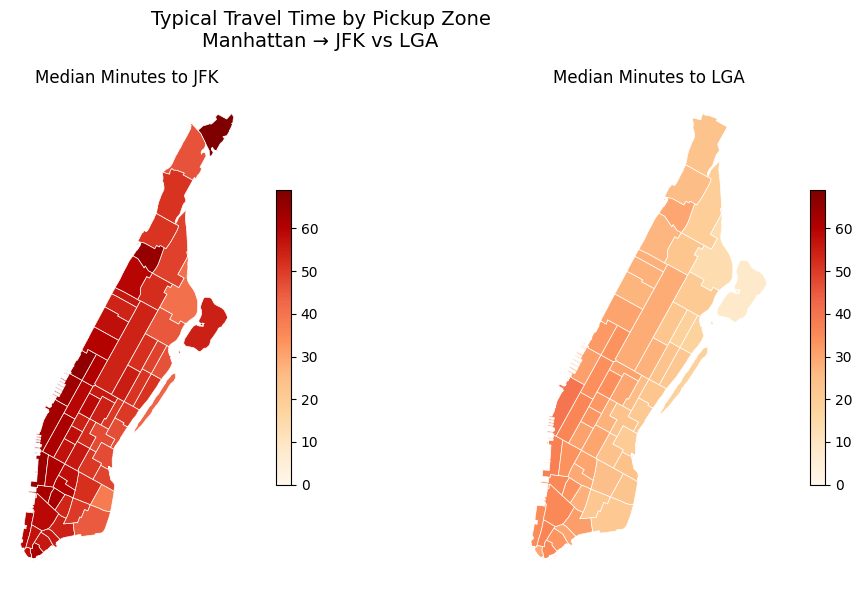

In [ ]:
# Cell 7 – plot side-by-side median-duration maps (JFK vs LGA)

# Shared color scale across both airports
max_median = manhattan_durations[["median_to_JFK", "median_to_LGA"]].max().max()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for col, title, ax in zip(
    ["median_to_JFK", "median_to_LGA"],
    ["Median Minutes to JFK", "Median Minutes to LGA"],
    axes
):
    manhattan_durations.plot(
        column=col,
        cmap="OrRd",
        linewidth=0.5,
        edgecolor="white",
        ax=ax,
        legend=True,
        vmin=0,
        vmax=max_median,
        legend_kwds={"shrink": 0.6}
    )
    ax.set_axis_off()
    ax.set_title(title, fontsize=12)

plt.suptitle(
    "Typical Travel Time by Pickup Zone\nManhattan → JFK vs LGA",
    fontsize=14
)
plt.tight_layout()
plt.savefig("manhattan_median_duration_jfk_lga.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# Cell 8 – compute 'late' label using route–time cells

airport_trips = airport_trips.copy()

# Features for grouping: hour of day and day of week from pickup time
airport_trips["pickup_hour"] = airport_trips["pickup_dt"].dt.hour
airport_trips["pickup_dow"]  = airport_trips["pickup_dt"].dt.dayofweek  # 0=Mon, 6=Sun

group_cols = ["PULocationID", "DOLocationID", "pickup_hour", "pickup_dow"]

# Typical (median) trip minutes for each route–time cell
typical_times = (
    airport_trips
      .groupby(group_cols)["trip_minutes"]
      .median()
      .reset_index(name="median_minutes_cell")
)

# Join back onto each trip
airport_trips = airport_trips.merge(typical_times, on=group_cols, how="left")

# Define late: > 20% above typical time for that cell
airport_trips["late"] = (
    airport_trips["trip_minutes"] > 1.2 * airport_trips["median_minutes_cell"]
).astype(int)

airport_trips[["PULocationID", "DOLocationID", "trip_minutes",
               "median_minutes_cell", "late"]].head()

,PULocationID,DOLocationID,trip_minutes,median_minutes_cell,late
0,230.0,132.0,31.466667,31.466667,0
1,230.0,132.0,31.466667,31.466667,0
2,164.0,132.0,29.300000,29.300000,0
3,224.0,132.0,28.866667,28.866667,0
4,48.0,132.0,31.566667,31.566667,0


In [ ]:
# Cell 9 – late rate per pickup zone (Manhattan → JFK/LGA)

zone_late = (
    airport_trips
      .groupby("PULocationID")["late"]
      .mean()
      .reset_index(name="late_rate")
)

zone_late.describe()

# Join onto Manhattan shapes (manhattan_shapes already defined earlier)
manhattan_risk = manhattan_shapes.merge(
    zone_late,
    how="left",
    left_on="LocationID",
    right_on="PULocationID"
)

# Zones with no airport trips get late_rate = 0
manhattan_risk["late_rate"] = manhattan_risk["late_rate"].fillna(0)

manhattan_risk[["LocationID", "zone", "late_rate"]].head()


,LocationID,zone,late_rate
0,4,Alphabet City,0.000000
1,12,Battery Park,0.000000
2,13,Battery Park City,0.077083
3,24,Bloomingdale,0.015625
4,41,Central Harlem,0.011494


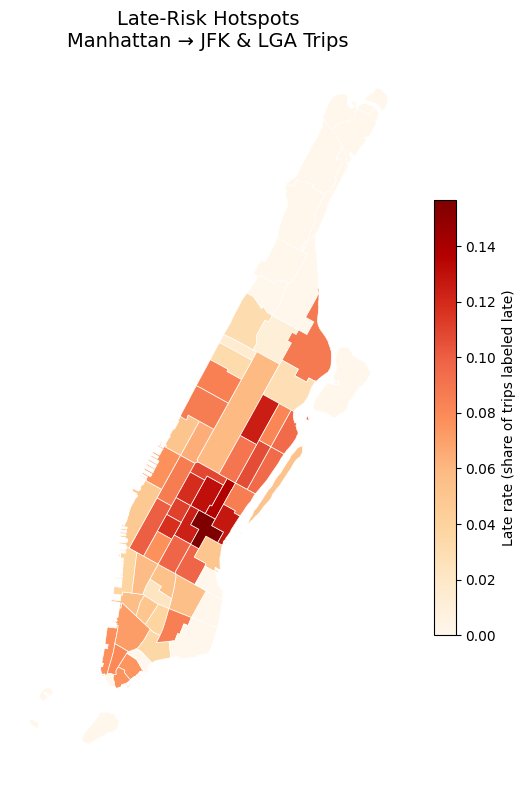

In [ ]:
# Cell 10 – plot late-risk heatmap for Manhattan → JFK/LGA

fig, ax = plt.subplots(figsize=(6, 8))

manhattan_risk.plot(
    column="late_rate",
    cmap="OrRd",
    linewidth=0.5,
    edgecolor="white",
    ax=ax,
    legend=True,
    legend_kwds={
        "label": "Late rate (share of trips labeled late)",
        "shrink": 0.6
    }
)

ax.set_axis_off()
ax.set_title("Late-Risk Hotspots\nManhattan → JFK & LGA Trips", fontsize=14)

plt.tight_layout()
plt.savefig("manhattan_late_risk_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()


extra visual:

In [ ]:
!pip install seaborn --quiet

import seaborn as sns


In [ ]:
# Late rate by airport (JFK / LGA) and time-of-week (day, hour)

# Ensure we have pickup_hour and pickup_dow (if coming from a fresh kernel)
if "pickup_hour" not in airport_trips.columns or "pickup_dow" not in airport_trips.columns:
    airport_trips["pickup_hour"] = airport_trips["pickup_dt"].dt.hour
    airport_trips["pickup_dow"]  = airport_trips["pickup_dt"].dt.dayofweek  # 0=Mon, 6=Sun

airport_time_risk = (
    airport_trips
      .groupby(["DOLocationID", "pickup_dow", "pickup_hour"])["late"]
      .mean()
      .reset_index(name="late_rate")
)

airport_time_risk.head()


,DOLocationID,pickup_dow,pickup_hour,late_rate
0,132.0,0,0,0.000000
1,132.0,0,1,0.000000
2,132.0,0,2,0.000000
3,132.0,0,3,0.000000
4,132.0,0,4,0.086207


In [ ]:
# Day-of-week labels for nicer axis ticks
dow_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Global max late rate to share color scale across JFK / LGA
max_late_rate = airport_time_risk["late_rate"].max()

def plot_airport_heatmap(airport_id, title, ax):
    data = airport_time_risk[airport_time_risk["DOLocationID"] == airport_id]

    # Pivot to day (rows) x hour (cols)
    pivot = (
        data
          .pivot(index="pickup_dow", columns="pickup_hour", values="late_rate")
          .reindex(index=range(7))   # ensure all days in order
    )

    sns.heatmap(
        pivot,
        ax=ax,
        cmap="OrRd",
        vmin=0,
        vmax=max_late_rate,
        cbar=True,
        cbar_kws={"shrink": 0.7}
    )

    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Pickup hour of day")
    ax.set_ylabel("Day of week")
    ax.set_yticks(np.arange(0.5, 7.5))
    ax.set_yticklabels(dow_labels, rotation=0)
    ax.set_xticks(np.arange(0.5, 24.5, 3))
    ax.set_xticklabels(range(0, 24, 3))


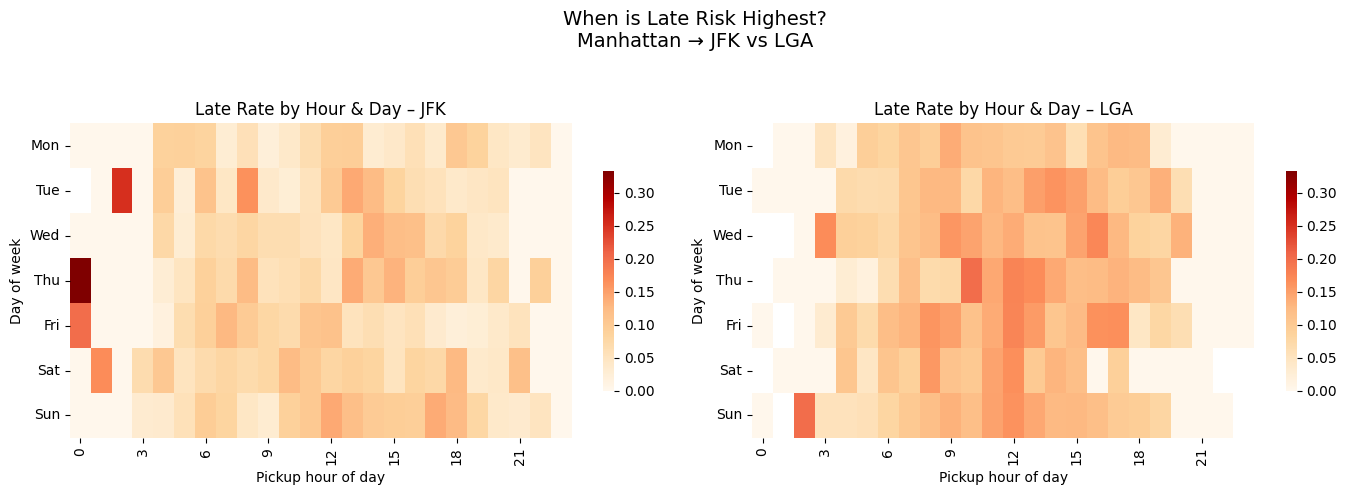

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_airport_heatmap(jfk_id, "Late Rate by Hour & Day – JFK", axes[0])
plot_airport_heatmap(lga_id, "Late Rate by Hour & Day – LGA", axes[1])

plt.suptitle("When is Late Risk Highest?\nManhattan → JFK vs LGA", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.94])

plt.savefig("late_risk_hour_day_heatmaps.png", dpi=300, bbox_inches="tight")
plt.show()


## How Much Buffer Do You Need?

In [ ]:
# Ensure we have hour and day-of-week
airport_trips["pickup_hour"] = airport_trips["pickup_dt"].dt.hour
airport_trips["pickup_dow"]  = airport_trips["pickup_dt"].dt.dayofweek  # 0=Mon..6=Sun

# Filter to Manhattan -> JFK only
jfk_trips = airport_trips[airport_trips["DOLocationID"] == jfk_id].copy()

# Define "weekday peak" and "weekday off-peak" windows
weekday_mask = jfk_trips["pickup_dow"].between(0, 4)  # Mon–Fri

peak_mask = weekday_mask & jfk_trips["pickup_hour"].between(16, 19)   # 4–7 pm
offpeak_mask = weekday_mask & jfk_trips["pickup_hour"].between(10, 13)  # 10 am–1 pm

peak_trips = jfk_trips.loc[peak_mask, "trip_minutes"]
offpeak_trips = jfk_trips.loc[offpeak_mask, "trip_minutes"]

peak_trips.describe(), offpeak_trips.describe()

(count    2575.000000
 mean       62.933482
 std        13.488689
 min         3.616667
 25%        53.766667
 50%        62.400000
 75%        71.050000
 max       137.400000
 Name: trip_minutes, dtype: float64,
 count    3025.000000
 mean       59.419273
 std        11.189300
 min         6.583333
 25%        51.550000
 50%        58.800000
 75%        66.216667
 max       119.916667
 Name: trip_minutes, dtype: float64)

In [ ]:
def buffer_curve(trip_minutes, max_buffer=60, step=5):
    """
    Given a Series of trip durations (minutes), compute probability of
    trip_minutes > median + buffer for a grid of buffer values.
    """
    trip_minutes = trip_minutes.dropna()
    median = trip_minutes.median()

    buffers = np.arange(0, max_buffer + step, step)
    probs = [(trip_minutes > median + b).mean() for b in buffers]
    return buffers, probs, median


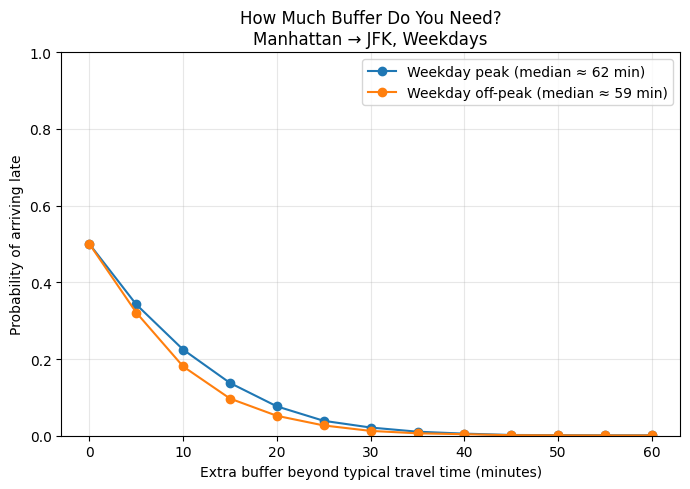

In [ ]:
buffers, peak_probs, peak_median = buffer_curve(peak_trips, max_buffer=60, step=5)
_, off_probs, off_median = buffer_curve(offpeak_trips, max_buffer=60, step=5)

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(buffers, peak_probs, marker="o",
        label=f"Weekday peak (median ≈ {peak_median:.0f} min)")
ax.plot(buffers, off_probs, marker="o",
        label=f"Weekday off-peak (median ≈ {off_median:.0f} min)")

ax.set_xlabel("Extra buffer beyond typical travel time (minutes)")
ax.set_ylabel("Probability of arriving late")
ax.set_title("How Much Buffer Do You Need?\nManhattan → JFK, Weekdays")
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig("buffer_vs_late_prob_jfk.png", dpi=300, bbox_inches="tight")
plt.show()


## Late-Risk by Neighborhood and Time of Day (3-panel map)

In [ ]:
# Make sure pickup_hour exists
airport_trips["pickup_hour"] = airport_trips["pickup_dt"].dt.hour

# Define time windows (you can tweak these hour ranges if needed)
windows = [
    ("Morning (6–10)", list(range(6, 11))),    # 6,7,8,9,10
    ("Midday (11–15)", list(range(11, 16))),   # 11,12,13,14,15
    ("Evening (16–20)", list(range(16, 21)))   # 16,17,18,19,20
]

risk_maps = []
max_late = 0.0

for label, hours in windows:
    # Filter trips in this time window
    df_win = airport_trips[airport_trips["pickup_hour"].isin(hours)]

    # Late rate per pickup zone
    zone_late = (
        df_win
          .groupby("PULocationID")["late"]
          .mean()
          .reset_index(name="late_rate")
    )

    # Join onto Manhattan polygons
    manhattan_win = manhattan_shapes.merge(
        zone_late,
        how="left",
        left_on="LocationID",
        right_on="PULocationID"
    )

    manhattan_win["late_rate"] = manhattan_win["late_rate"].fillna(0.0)
    manhattan_win["window_label"] = label

    risk_maps.append(manhattan_win)
    max_late = max(max_late, manhattan_win["late_rate"].max())

max_late


0.3333333333333333

In [ ]:
# After df_win is created in your window loop
counts = (
    df_win.groupby("PULocationID")
          .size()
          .reset_index(name="n_trips")
)

zone_late = zone_late.merge(counts, on="PULocationID", how="left")

# Mask zones with very few trips (e.g., < 30) so they don't show noisy late rates
min_trips = 30
zone_late.loc[zone_late["n_trips"] < min_trips, "late_rate"] = np.nan


In [ ]:
vmin, vmax = 0.03, max_late


/tmp/ipython-input-2596371099.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.96, 0.92])


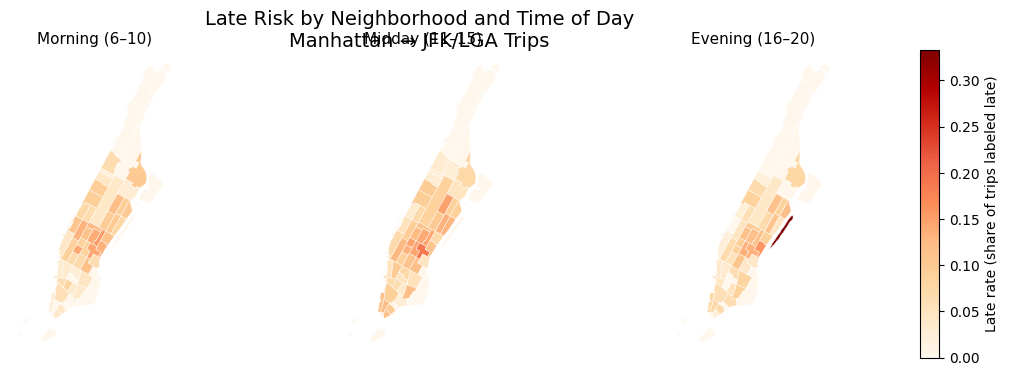

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Shared color scale across all windows
vmin, vmax = 0, max_late  # you already computed max_late above

fig = plt.figure(figsize=(13, 4))

# 3 map columns + 1 narrow colorbar column
gs = fig.add_gridspec(
    1, 4,
    width_ratios=[1, 1, 1, 0.06],
    wspace=0.02
)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])

for ax, manhattan_win, (label, _) in zip(axes, risk_maps, windows):
    manhattan_win.plot(
        column="late_rate",
        cmap="OrRd",
        linewidth=0.3,
        edgecolor="white",
        ax=ax,
        legend=False,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_axis_off()
    ax.set_title(label, fontsize=11, pad=4)

# Shared colorbar
cmap = plt.cm.OrRd
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Late rate (share of trips labeled late)")

fig.suptitle(
    "Late Risk by Neighborhood and Time of Day\nManhattan → JFK/LGA Trips",
    fontsize=14,
    y=0.98
)

plt.tight_layout(rect=[0, 0, 0.96, 0.92])
plt.savefig("late_risk_by_time_windows_maps_clean.png",
            dpi=300, bbox_inches="tight")
plt.show()
